In [2]:
# Import necessary libraries
import os
import pandas as pd


import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [4]:
# Paths
data_dir = 'data/training'  # Folder with .tif images
csv_file = 'data/training.csv'  # CSV file with image_id and is_homogeneous


In [5]:
# Load the CSV file
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip()
df.rename(columns={'is_homogenous': 'is_homogeneous'}, inplace=True)


In [6]:
# Create image paths and labels
image_paths = [os.path.join(data_dir, f"{str(image_id).zfill(3)}.tif") for image_id in df['image_id']]
labels = df['is_homogeneous'].values

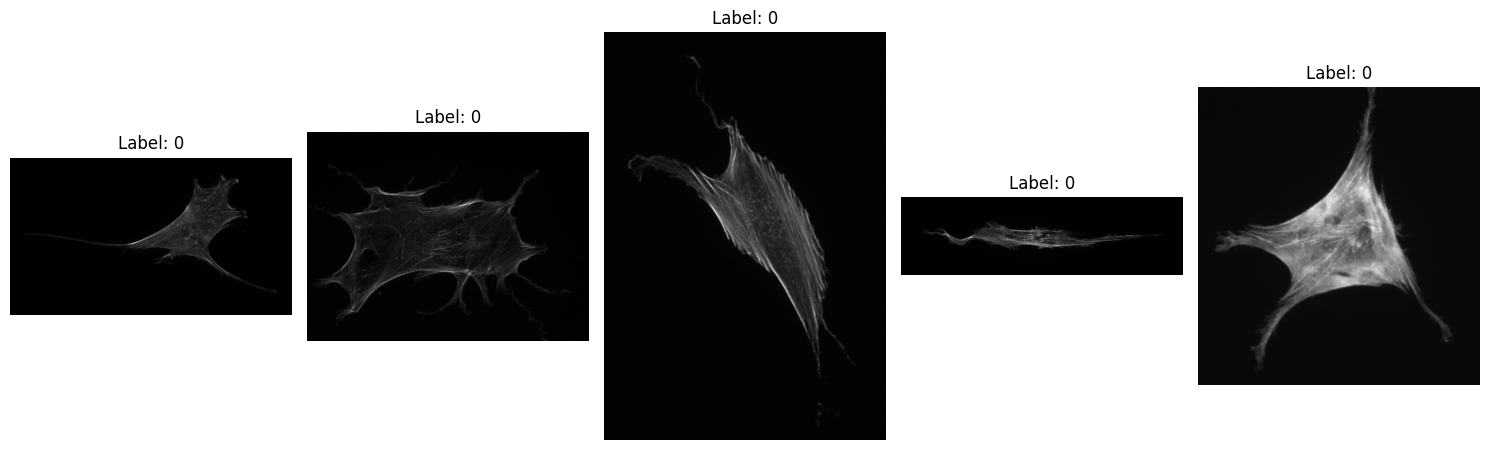

In [7]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Number of random samples to take
num_samples = 5

# Randomly select 5 indices
random_indices = random.sample(range(len(image_paths)), num_samples)

# Plot the selected images and their labels
plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img_path = image_paths[idx]
    label = labels[idx]
    
    # Load image
    img = mpimg.imread(img_path)
    
    # Create subplot for each image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')  # Assuming grayscale images, adjust cmap if necessary
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [8]:
# Stratify split to maintain class distribution
train_paths, val_paths, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [9]:
# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

In [10]:
# Separate majority and minority classes
train_paths_majority = [path for path, label in zip(train_paths, y_train) if label == 0]
train_labels_majority = [0] * len(train_paths_majority)

train_paths_minority = [path for path, label in zip(train_paths, y_train) if label == 1]
train_labels_minority = [1] * len(train_paths_minority)


In [11]:
print(f"Majority class samples: {len(train_labels_majority)}")
print(f"Minority class samples: {len(train_labels_minority)}")

Majority class samples: 92
Minority class samples: 19


In [12]:
# Calculate the number of augmented images needed
num_majority_samples = len(train_labels_majority)
num_minority_samples = len(train_labels_minority)
num_augmented_images_needed = num_majority_samples - num_minority_samples


In [13]:
print(f"Number of augmented images needed: {num_augmented_images_needed}")


Number of augmented images needed: 73


In [14]:
augment_times = num_augmented_images_needed // num_minority_samples + 1


In [15]:
augment_times

4

In [23]:
# Define transforms
# Common transformations for all datasets
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize as per ImageNet
                         std=[0.229, 0.224, 0.225])
])


In [24]:
# Augmentation transformations for the augmented dataset
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [25]:
# Define custom datasets
class CellDataset(Dataset):
    def __init__(self, image_paths, labels, transform=common_transforms):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform  # Use common transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path)
            # Handle different image modes
            if image.mode.startswith('I;16'):
                # Convert 16-bit image to 8-bit
                numpy_image = np.array(image, dtype=np.uint16)
                numpy_image = (numpy_image / 256).astype('uint8')
                image = Image.fromarray(numpy_image, mode='L')
                image = image.convert('RGB')
            else:
                image = image.convert('RGB')

            # Apply transforms
            if self.transform:
                image = self.transform(image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return image, label
        

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, augment_times=1, transform=augmentation_transforms):
        self.image_paths = image_paths
        self.labels = labels
        self.augment_times = augment_times
        self.transform = transform  # Use augmentation transforms

    def __len__(self):
        return len(self.image_paths) * self.augment_times

    def __getitem__(self, idx):
        actual_idx = idx % len(self.image_paths)
        image_path = self.image_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            image = Image.open(image_path)
            # Handle different image modes
            if image.mode.startswith('I;16'):
                # Convert 16-bit image to 8-bit
                numpy_image = np.array(image, dtype=np.uint16)
                numpy_image = (numpy_image / 256).astype('uint8')
                image = Image.fromarray(numpy_image, mode='L')
                image = image.convert('RGB')
            else:
                image = image.convert('RGB')

            # Apply transforms
            if self.transform:
                image = self.transform(image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return image, label
        

In [26]:
# Create datasets
majority_dataset = CellDataset(train_paths_majority, train_labels_majority)
augmented_minority_dataset = AugmentedDataset(
    train_paths_minority,
    train_labels_minority,
    augment_times=augment_times
)



In [27]:
# Combine datasets using ConcatDataset
train_dataset = ConcatDataset([majority_dataset, augmented_minority_dataset])



In [28]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CellDataset(val_paths, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [29]:
# Test data loading
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print(f"Inputs type: {type(inputs)}, Inputs shape: {inputs.shape}")
    print(f"Labels type: {type(labels)}, Labels shape: {labels.shape}")
    break  # Test with the first batch



Loading image from: data/training/077.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/111.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/055.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/003.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/111.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/141.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/021.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>


In [30]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)


/Users/costelgutu/Projects/DM-i-AI-2024/cell-classification/.cellclass/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/costelgutu/Projects/DM-i-AI-2024/cell-classification/.cellclass/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/costelgutu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [31]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False



In [32]:
# Unfreeze the last layers (layer4 and fc)
for name, child in model.named_children():
    if name == 'layer4' or name == 'fc':
        for param in child.parameters():
            param.requires_grad = True
            

In [33]:
num_ftrs = model.fc.in_features



In [34]:
# Define custom classifier
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)


In [35]:
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.BCELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Training loop
num_epochs = 30
best_val_loss = np.inf
early_stopping_patience = 5
epochs_no_improve = 0



In [37]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1)

            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)

            preds = (outputs >= 0.5).long().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print('Early stopping!')
            break



Loading image from: data/training/061.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/219.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/075.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/079.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/075.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/153.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/141.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>


In [38]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


/var/folders/2y/yqnrgs455nqbkzys9jk4k0sm0000gn/T/ipykernel_75728/3309732638.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
# Evaluate on validation set
all_preds = []
all_labels = []


In [40]:
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        outputs = outputs.view(-1)

        preds = (outputs >= 0.5).long().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        

In [41]:
# Print classification report
print(classification_report(all_labels, all_preds, target_names=['Heterogeneous', 'Homogeneous']))



               precision    recall  f1-score   support

Heterogeneous       0.87      0.87      0.87        23
  Homogeneous       0.40      0.40      0.40         5

     accuracy                           0.79        28
    macro avg       0.63      0.63      0.63        28
 weighted avg       0.79      0.79      0.79        28



In [42]:
# Calculate custom score
y_val_np = np.array(all_labels)
predicted_labels_np = np.array(all_preds)

n_0 = np.sum(y_val_np == 0)
n_1 = np.sum(y_val_np == 1)
a_0 = np.sum((y_val_np == 0) & (predicted_labels_np == 0))
a_1 = np.sum((y_val_np == 1) & (predicted_labels_np == 1))

if n_0 == 0 or n_1 == 0:
    score = 0
else:
    score = (a_0 * a_1) / (n_0 * n_1)

print(f'Score: {score}')


Score: 0.34782608695652173


In [43]:
# Check lengths of datasets
len_majority_dataset = len(majority_dataset)
len_minority_dataset = len(train_paths_minority)
len_augmented_minority_dataset = len(augmented_minority_dataset)
len_train_dataset = len(train_dataset)

print(f"Length of Majority Dataset: {len_majority_dataset}")
print(f"Length of Minority Dataset (before augmentation): {len_minority_dataset}")
print(f"Augmentation Times: {augment_times}")
print(f"Length of Augmented Minority Dataset: {len_augmented_minority_dataset}")
print(f"Length of Combined Training Dataset: {len_train_dataset}")

# Verify class balance in the combined training dataset
count_class_0 = 0
count_class_1 = 0

for _, label in train_dataset:
    if label == 0:
        count_class_0 += 1
    elif label == 1:
        count_class_1 += 1

print(f"Number of Majority Class Samples in Training Dataset: {count_class_0}")
print(f"Number of Minority Class Samples in Training Dataset: {count_class_1}")


Length of Majority Dataset: 92
Length of Minority Dataset (before augmentation): 19
Augmentation Times: 4
Length of Augmented Minority Dataset: 76
Length of Combined Training Dataset: 168
Loading image from: data/training/153.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/055.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/061.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/259.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/085.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Loading image from: data/training/079.tif
Image type after opening: <cla

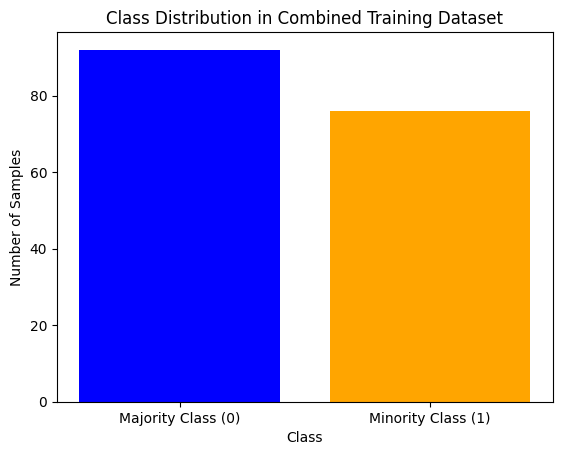

In [44]:
import matplotlib.pyplot as plt

# Class counts
classes = ['Majority Class (0)', 'Minority Class (1)']
counts = [count_class_0, count_class_1]

# Plotting
plt.bar(classes, counts, color=['blue', 'orange'])
plt.title('Class Distribution in Combined Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()



In [45]:
# Specify the PATH where you want to save the model
MODEL_PATH = 'best_model_state_dict.pth'

# Save the state dictionary
torch.save(model.state_dict(), MODEL_PATH)



In [ ]:
# Specify the PATH where you want to save the model
MODEL_PATH = 'best_model_entire.pth'

# Save the entire model
torch.save(model, MODEL_PATH)
